# Web Scrapping
#### Project: Extract feedback suggestions from Mutual website
#### Source: feedback.mutual.app
#### Monetization: Non-commercial use
#### Author: Pedro Sanhueza

In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime

In [4]:
# running time: 7 minutes
rows_info = []
rows_votes = []
rows_description=[]

for pag in range(7): # '7' because there are 7 pages
    url = f'https://feedback.mutual.app/?page={pag+1}&order=popular&filter=all#controls' # url for each page. only change the page number
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    info = soup.find_all('div',{'class':'sInfo'})
    votes= soup.find_all('div',{'class':'sNumbers'})

    #************* INFO DICTIONARARY *************
    for attribute in info:
        row = {}
        row['id'] = attribute.find('a')['href'].split('/')[2]
        row['suggestion'] = attribute.find('a')['href'].split('/')[-1].replace('-',' ').capitalize()
        row['author'] = attribute.find_all('strong')[0].get_text()

        start = attribute.find_all('span')[0].get_text(strip=True).find('(')+1
        end = attribute.find_all('span')[0].get_text(strip=True).find(')')
        
        row['date_created'] = attribute.find_all('span')[0].get_text(strip=True)[start:end].replace('\'','20')
        row['last_upvoted'] = attribute.find_all('span',{'class':'sLastComment'})[0].get_text(strip=True)[9:].replace('\'','20')
        row['comments'] = attribute.find_all('span',{'class':'sLabel'})[0].get_text(strip=True)[10:]
        try:
            row['status'] = attribute.find_all('div',{'class':'sLabels'})[0].get_text(strip=True).replace('Pinned','')
        except:
            pass
            # pass 
        rows_info.append(row)

    #************* VOTES DICTIONARARY *************
    for attribute in votes:
        row = {}
        row['votes'] = attribute.find('a').get_text(strip=True)[:-5].replace('K','000')
        rows_votes.append(row)

    # ************* DESCRIPTION DICTIONARARY *************
    for attribute in info:
        url = f'https://feedback.mutual.app'+attribute.find('a')['href']
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
        row = {}
        p = soup.find('div',{'class':'suggestionDescription'}).get_text().strip()
        row['Description'] = p.encode('ascii','replace').decode().replace('???','\'')
        rows_description.append(row)


    #************* JOIN *************
    for idx,e in enumerate(rows_votes):
        rows_info[idx].update(e)

    for idx,e in enumerate(rows_description):
        rows_info[idx].update(e)

In [5]:
data = pd.DataFrame(rows_info)

date = datetime.now().strftime("%d-%m-%Y %H%M%S") # get local time as string

filePath = "../Mutual - Historical Data/MutualFeedback " + date + " - Webscrape.csv"

data.to_csv(filePath, index=True) # save to file path

data

,id,suggestion,author,date_created,last_upvoted,comments,status,votes,Description
0,161005,See who i have liked,Moses,"19 Feb, 2021",today,72,Planned,1000,A feature that allows you to see a queue of us...
1,161962,Last onlinerecently active,Moses,"22 Feb, 2021",today,48,In Development,527,A feature that allows you to see how active a ...
2,164928,Filter church activity,Moses,"01 Mar, 2021",11 Aug,42,Done,458,The current options we are thinking of are: \r...
3,177816,Skip a profile save for later,Brian,"11 Apr, 2021",today,36,Under consideration,401,A feature to let you skip a profile and have i...
4,296565,Remove swipe limit,Sheppard,30 Apr,yesterday,41,Under consideration,252,"As someone who doesn't get tons of matches, it..."
...,...,...,...,...,...,...,...,...,...
329,189058,Viajes a distintos paises,Yanina,"04 Jun, 2021","04 Jun, 2021",0,Bug,1,Tener la oportunidad que se pueda elegir el pa...
330,187811,When i leave a conversation dont jump back to ...,Swaggy Shaggs,"27 May, 2021","27 May, 2021",0,Bug,1,When I leave a conversation it automatically j...
331,186869,Add the word peru,Steven Spainhower,"22 May, 2021","22 May, 2021",0,Bug,1,On gray page of options on how to increase the...
332,183884,Yes i already paid for this site but when i go...,Edward Davis,"06 May, 2021","06 May, 2021",0,Bug,1,


# Explanatory Data Analysis

In [6]:
import plotly.express as px

In [7]:
# change dtype
data = data.astype({'votes': 'float','comments': 'float'}, copy=True)

# add column with months
data['date_created_month'] = data['date_created'].apply(lambda x: x.split(' ')[1].replace(',',''))
data['date_created_month']=data['date_created_month'].replace({'Fe':'Feb','Ap':'Apr','Ma':'May'})

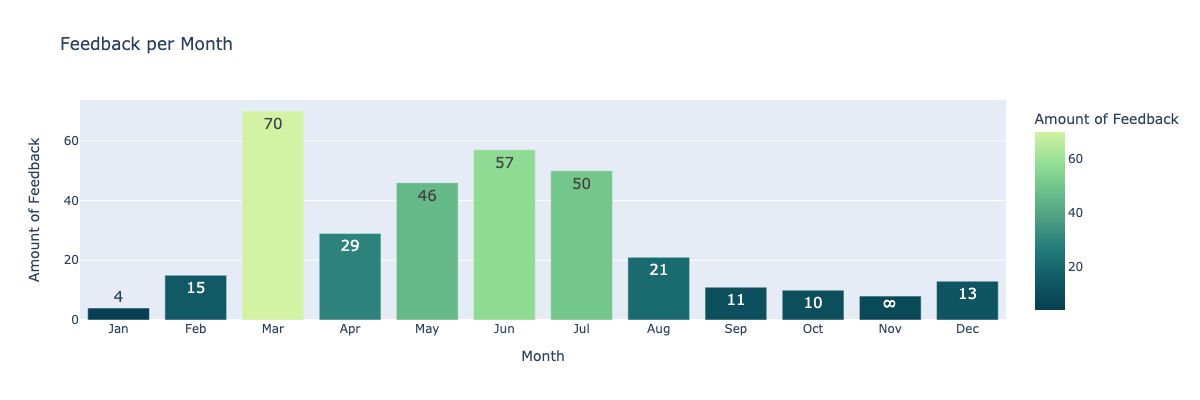

In [8]:
data_month = data['date_created_month'].value_counts().reset_index()
order = {'index':['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']}

fig = px.bar(
    data_month,
    x='index',
    y='date_created_month',
    color='date_created_month',
    # color_continuous_scale=px.colors.sequential.Viridis,
    color_continuous_scale=str(px.colors.named_colorscales()[15])+'_r',
    category_orders=order,
    width=1200,
    height=400,
    text_auto=True,
    labels={"index":"Month","date_created_month":"Amount of Feedback"},
    title="Feedback per Month"
)

fig.update_traces(textfont_size=15)

fig.show('png')

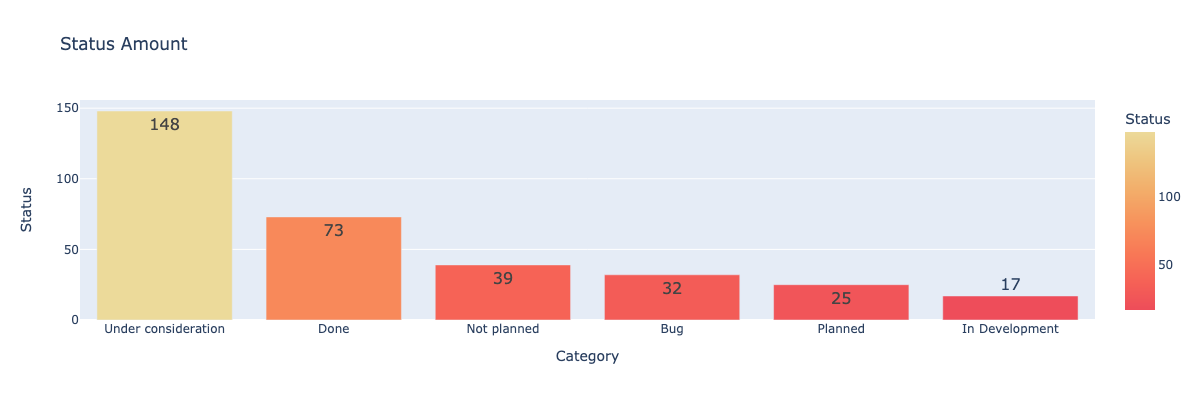

In [9]:

data_status = data['status'].value_counts().reset_index()
x_axis = data_status['index']

fig = px.bar(
    data_status,
    x='index',
    y='status',
    color='status',
    # color_continuous_scale=px.colors.sequential.Viridis,
    color_continuous_scale=str(px.colors.named_colorscales()[27])+'_r',
    width=1200,
    height=400,
    text_auto=True,
    title="Status Amount",
    labels={"index":"Category","status":"Status"},
)

fig.update_layout(xaxis={'categoryorder':'total descending'})

fig.update_traces(textfont_size=16)

fig.show('png')

In [10]:
# Top 10 (by vote count) features already implemented:
data[data.status=='Done'][:10].sort_values('votes', ascending=False)

,id,suggestion,author,date_created,last_upvoted,comments,status,votes,Description,date_created_month
2,164928,Filter church activity,Moses,"01 Mar, 2021",11 Aug,42.0,Done,458.0,The current options we are thinking of are: \r...,Mar
5,161959,Filter children,Moses,"22 Feb, 2021",today,22.0,Done,251.0,Filter users based on if they have children or...,Feb
6,161947,Filter interest level,Moses,"22 Feb, 2021",09 Aug,37.0,Done,236.0,"Currently, we allow you to scale your dating i...",Feb
15,157427,Video chat,Moses,"03 Feb, 2021",today,22.0,Done,184.0,Add the video chat feature so users can video ...,Feb
16,164962,Hide inactive profiles,Dallin,"02 Mar, 2021",2 days ago,2.0,Done,171.0,Profiles that are inactive are hidden after an...,Mar
17,161961,Conversation prompts,Moses,"22 Feb, 2021",09 Aug,24.0,Done,165.0,It would be nice to have different conversatio...,Feb
18,165319,Higher character count in bio,Qaseem,"02 Mar, 2021",22 Jul,17.0,Done,151.0,Increase the current character count by 150-20...,Mar
19,164933,Filter temple recommend,Moses,"01 Mar, 2021",08 Aug,14.0,Done,144.0,Filter through users who have a current temple...,Mar
20,161963,Filter politics,Moses,"22 Feb, 2021",30 Jul,22.0,Done,139.0,"Republican, Democrat, Libertarian, other?",Feb
21,175881,Free trial,Erica,"01 Apr, 2021",2 days ago,25.0,Done,137.0,do a promo or let us watch adds to have a 24 h...,Apr


In [11]:
# Top 10 votes features not done:
data[data.status!='Done'].sort_values('votes', ascending=False)[:10]

,id,suggestion,author,date_created,last_upvoted,comments,status,votes,Description,date_created_month
0,161005,See who i have liked,Moses,"19 Feb, 2021",today,72.0,Planned,1000.0,A feature that allows you to see a queue of us...,Feb
11,168489,Let queer members match with other queer members,Rachel,"10 Mar, 2021",08 Aug,96.0,Under consideration,1000.0,There are so many queer lds members that are t...,Mar
1,161962,Last onlinerecently active,Moses,"22 Feb, 2021",today,48.0,In Development,527.0,A feature that allows you to see how active a ...,Feb
12,170983,Watch an ad to see a person who likes you,Anonymous,"19 Mar, 2021",2 days ago,27.0,Under consideration,501.0,"You have ads that pop up occasionally anyway,...",Mar
3,177816,Skip a profile save for later,Brian,"11 Apr, 2021",today,36.0,Under consideration,401.0,A feature to let you skip a profile and have i...,Apr
13,165279,Birthday surprise,Jefferson Glenn,"02 Mar, 2021",2 days ago,9.0,Under consideration,261.0,"On the Mutual user's birthday, they will be up...",Mar
4,296565,Remove swipe limit,Sheppard,30 Apr,yesterday,41.0,Under consideration,252.0,"As someone who doesn't get tons of matches, it...",Apr
14,161000,Dark mode,Moses,"19 Feb, 2021",2 days ago,9.0,Under consideration,193.0,Light-on-dark color scheme. This color scheme ...,Feb
7,169459,Voice messaging,Johnson Daniel Kalu,"15 Mar, 2021",13 Aug,11.0,Under consideration,181.0,"Use voice notes in addition to typing, makes c...",Mar
8,165044,Neighboring countries filter,Erik,"02 Mar, 2021",today,16.0,Under consideration,139.0,Add the filter for ' neighboring countries'. F...,Mar


In [ ]:
rows = []
rows_votes = []

for pag in range(7): # '7' because there are 7 pages
    
    url = f'https://feedback.mutual.app/?page={pag+1}&order=popular&filter=all#controls' # url for each page. only change the page number
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    info = soup.find_all('div',{'class':'sInfo'})
    votes= soup.find_all('div',{'class':'sNumbers'})

    for attribute in info:
        row = {}
        row['id'] = attribute.find('a')['href'].split('/')[2]
        row['suggestion'] = attribute.find('a')['href'].split('/')[-1].replace('-',' ').capitalize()
        row['author'] = attribute.find_all('strong')[0].get_text()
        start = attribute.find_all('span')[0].get_text(strip=True).find('(')+1
        end = attribute.find_all('span')[0].get_text(strip=True).find(')')
        row['date_created'] = attribute.find_all('span')[0].get_text(strip=True)[start:end].replace('\'','20')
        row['last_upvoted'] = attribute.find_all('span',{'class':'sLastComment'})[0].get_text(strip=True)[9:]
        row['comments'] = attribute.find_all('span',{'class':'sLabel'})[0].get_text(strip=True)[10:]
        try:
            row['status'] = attribute.find_all('div',{'class':'sLabels'})[0].get_text(strip=True).replace('Pinned','')
        except:
            pass
        rows.append(row)

    for attribute in votes:
        row = {}
        row['votes'] = attribute.find('a').get_text(strip=True)[:-5].replace('K','000')
        rows_votes.append(row)

    for idx,e in enumerate(rows):
        rows_votes[idx].update(e)

In [ ]:
pd.DataFrame(rows_votes)

,votes,id,suggestion,author,date_created,last_upvoted,comments,status
0,1000,161005,See who i have liked,Moses,"19 Feb, 2021",today,72,Planned
1,507,161962,Last onlinerecently active,Moses,"22 Feb, 2021",today,46,In Development
2,444,164928,Filter church activity,Moses,"01 Mar, 2021",today,41,In Development
3,365,177816,Skip a profile save for later,Brian,"11 Apr, 2021",today,35,Under consideration
4,240,161959,Filter children,Moses,"22 Feb, 2021",today,21,In Development
...,...,...,...,...,...,...,...,...
315,1,187811,When i leave a conversation dont jump back to ...,Swaggy Shaggs,"27 May, 2021","27 May, '21",0,Bug
316,1,186869,Add the word peru,Steven Spainhower,"22 May, 2021","22 May, '21",0,Bug
317,1,183884,Yes i already paid for this site but when i go...,Edward Davis,"06 May, 2021","06 May, '21",0,Bug
318,1,183875,Ideal timeline,Sassafrass,"06 May, 2021","06 May, '21",0,Not planned
